<a href="https://colab.research.google.com/github/yongchenyen/Python/blob/main/RFM%E8%99%95%E7%90%86%E8%88%87%E5%AE%A2%E6%88%B6%E5%88%86%E7%BE%A4_%E7%B7%9A%E4%B8%8A%E9%9B%B6%E5%94%AE%E8%B3%87%E6%96%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 收集資料
首先，我們先要上述資料集簡化，只選取英國的銷售資料，且僅包括以下欄位：

顧客代碼
購買日期
發票金額
讀取檔案的程式如下，將日期轉成年月，以便作月統計：

In [ ]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UK-based and registered non-store online retail_簡化成只有英國資料 (2).csv",converters={'CustomerID':str})
# 轉成年月
df['date']=df.InvoiceDate.astype(np.str).str.slice(0,8).str.replace('-','')
df['date'] = pd.to_numeric(df['date'], errors='coerce')

In [ ]:
df.head()

,CustomerID,InvoiceNo,InvoiceDate,Total_Price,date
0,17850,536365.0,2010-12-01 08:26:00,15.30,201012
1,17850,536365.0,2010-12-01 08:26:00,20.34,201012
2,17850,536365.0,2010-12-01 08:26:00,22.00,201012
3,17850,536365.0,2010-12-01 08:26:00,20.34,201012
4,17850,536365.0,2010-12-01 08:26:00,20.34,201012


# 特徵工程
我事先已完成資料清理步驟，直接進行特徵工程，依據購買日期、發票金額，分別統計 -- 最近購買日期(Recency)、購買頻率(Frequency)及購買金額(Monetary)。

1. 計算最近購買日期(Recency)：將日期分成五個時段，找到
每個客戶最近購買的日期。

In [ ]:
def f(row):
    if row['date'] > 201110:
        val = 5
    elif row['date'] <= 201110 and row['date'] > 201108:
        val = 4
    elif row['date'] <= 201108 and row['date'] > 201106:
        val = 3
    elif row['date'] <= 201106 and row['date'] > 201104:
        val = 2
    else:
        val = 1
    return val
df_recency_1=df[['CustomerID','date']].drop_duplicates()
df_recency_1['Recency_Flag'] = df_recency_1.apply(f, axis=1)
df_recency = df_recency_1.groupby('CustomerID',as_index=False)['Recency_Flag'].max()

In [ ]:
df_recency.head(10)

,CustomerID,Recency_Flag
0,12346,1
1,12747,5
2,12748,5
3,12749,5
4,12820,5
5,12821,2
6,12822,4
7,12823,4
8,12824,4
9,12826,5


2. 計算購買頻率(Frequency)。


In [ ]:
Cust_freq=df[['InvoiceNo','CustomerID']].drop_duplicates()
#Calculating the count of unique purchase for each customer
Cust_freq_count=Cust_freq.groupby(['CustomerID'])['InvoiceNo'].aggregate('count').\
reset_index().sort_values('InvoiceNo', ascending=False, axis=0)

# Dividing in 5 equal parts
unique_invoice=Cust_freq_count[['InvoiceNo']]#.drop_duplicates()
unique_invoice['Freqency_Band'] = pd.qcut(unique_invoice['InvoiceNo'], 5)
unique_invoice=unique_invoice[['Freqency_Band']].drop_duplicates()
unique_invoice

,Freqency_Band
2,"(6.0, 210.0]"
782,"(3.0, 6.0]"
2358,"(2.0, 3.0]"
2798,"(1.0, 2.0]"
44,"(-0.001, 1.0]"


將頻率分成五個區間：

In [ ]:
def f2(row):
    if row['InvoiceNo'] < 1:
        val = 1
    elif row['InvoiceNo'] <= 2:
        val = 2
    elif row['InvoiceNo'] <= 3:
        val = 3
    elif row['InvoiceNo'] <= 6:
        val = 4
    else:
        val = 5
    return val

Cust_freq_count['Freq_Flag'] = Cust_freq_count.apply(f2, axis=1)

In [ ]:
Cust_freq_count['Freq_Flag'].value_counts()

2    2097
4     726
5     633
3     465
1      29
Name: Freq_Flag, dtype: int64

3. 計算購買金額(Monetary)。

In [ ]:
#Calculating the Sum of total monetary purchase for each customer
Cust_monetary = df.groupby(['CustomerID'])['Total_Price'].aggregate('sum').\
reset_index().sort_values('Total_Price', ascending=False)
# splitting Total price in 5 parts
unique_price=Cust_monetary[['Total_Price']].drop_duplicates()
unique_price=unique_price[unique_price['Total_Price'] > 0]
unique_price['monetary_Band'] = pd.qcut(unique_price['Total_Price'], 5)
unique_price=unique_price[['monetary_Band']].drop_duplicates()
unique_price

,monetary_Band
3811,"(1954.398, 256438.49]"
3416,"(900.882, 1954.398]"
3655,"(467.808, 900.882]"
858,"(244.286, 467.808]"
3661,"(-0.0009999999999964501, 244.286]"


將購買金額分成五個區間

In [ ]:
def f3(row):
    if row['Total_Price'] <= 243:
        val = 1
    elif row['Total_Price'] > 243 and row['Total_Price'] <= 463:
        val = 2
    elif row['Total_Price'] > 463 and row['Total_Price'] <= 892:
        val = 3
    elif row['Total_Price'] > 892 and row['Total_Price'] <= 1932:
        val = 4
    else:
        val = 5
    return val
Cust_monetary['Monetary_Flag'] = Cust_monetary.apply(f3, axis=1)

4. 合併RFM欄位

In [ ]:
Cust_All=pd.merge(df_recency,Cust_freq_count[['CustomerID','Freq_Flag']], on=['CustomerID'],how='left')
Cust_All=pd.merge(Cust_All,Cust_monetary[['CustomerID','Monetary_Flag']], on=['CustomerID'],how='left')
Cust_All.head(10)

,CustomerID,Recency_Flag,Freq_Flag,Monetary_Flag
0,12346,1,2,1
1,12747,5,5,5
2,12748,5,5,5
3,12749,5,4,5
4,12820,5,4,4
5,12821,2,2,1
6,12822,4,2,4
7,12823,4,4,4
8,12824,4,2,2
9,12826,5,5,4


# 集群分析
由於我們的目標只是要將現有的客戶分群，並沒有要預測新客戶，所以，不需要切割出測試資料，直接將全部資料丟進演算法作訓練。

這裡使用最簡單的 k-means 演算法，它必須先決定分幾群(即k)，通常，我們會使用elbow方法，計算 k=1,2,3,4, ..,n群時的損失函數(wcss)，找到CP值最高的k，程式如下：

In [ ]:
#Cust_All.drop(Cust_All.columns[0], axis=1, inplace=True)

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(Cust_All)
    wcss.append(kmeans.inertia_)

損失函數(wcss)為Y軸，k為X軸，作圖如下：

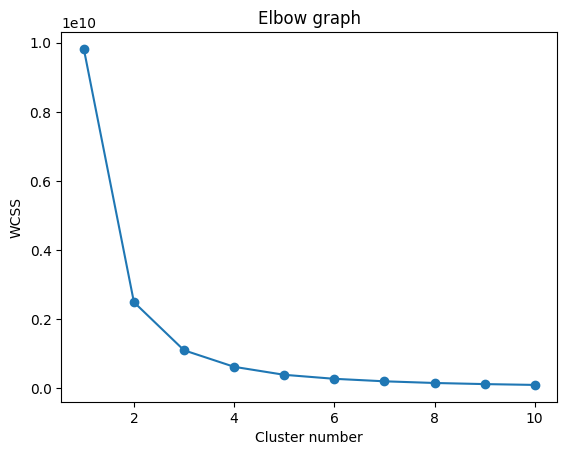

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

從上圖看，分成3、4、5、6群，都不錯，損失函數(wcss)都已壓低到一個程度，假設選4，我們就可以進一步計算每一群的質心：

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
Cust_All_2=Cust_All.drop(Cust_All.columns[0], axis=1)
Cust_All['clusters'] = kmeans.fit_predict(Cust_All_2)
Cust_All.tail(10)

,CustomerID,Recency_Flag,Freq_Flag,Monetary_Flag,clusters
3940,18273,5,3,1,3
3941,18274,5,2,1,3
3942,18276,5,2,2,3
3943,18277,4,2,1,3
3944,18278,4,2,1,3
3945,18280,1,2,1,0
3946,18281,2,2,1,0
3947,18282,5,2,1,3
3948,18283,5,5,5,2
3949,18287,4,3,4,1


In [ ]:
Cust_All_2.head()

,Recency_Flag,Freq_Flag,Monetary_Flag
0,1,2,1
1,5,5,5
2,5,5,5
3,5,4,5
4,5,4,4


結果如下，觀看R、F、M值，最大者就是VIP，由下表看就是第2集群(Cluster)，我們就可以列出VIP名單，好好的照顧他們，猛發EDM，攻佔他們的荷包。

In [ ]:
round(pd.DataFrame(kmeans.cluster_centers_),2)

,0,1,2
0,1.34,2.08,1.83
1,4.26,2.73,3.39
2,4.75,4.54,4.62
3,4.23,2.09,1.52


In [ ]:
Cust_All[Cust_All.clusters== 2]

,CustomerID,Recency_Flag,Freq_Flag,Monetary_Flag,clusters
1,12747,5,5,5,2
2,12748,5,5,5,2
3,12749,5,4,5,2
4,12820,5,4,4,2
7,12823,4,4,4,2
...,...,...,...,...,...
3929,18257,4,5,5,2
3930,18259,5,3,5,2
3931,18260,2,4,5,2
3939,18272,5,4,5,2


# silhoutte coefficient

In [ ]:
#Calculating the silhoutte coefficient
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans



for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(Cust_All_2)
    label = kmeans.labels_
    sil_coeff = silhouette_score(Cust_All_2, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.45815144136076935
For n_clusters=3, The Silhouette Coefficient is 0.48616044539702624
For n_clusters=4, The Silhouette Coefficient is 0.44860684562037106
For n_clusters=5, The Silhouette Coefficient is 0.43028040550554014
For n_clusters=6, The Silhouette Coefficient is 0.44701471205596355
For n_clusters=7, The Silhouette Coefficient is 0.43323866024984065
For n_clusters=8, The Silhouette Coefficient is 0.455055788528363
For n_clusters=9, The Silhouette Coefficient is 0.44825020350699
For n_clusters=10, The Silhouette Coefficient is 0.4682049594002352


In [ ]:
df2=Cust_All.merge(Cust_freq_count[['CustomerID', 'InvoiceNo']], on='CustomerID')
df2=df2.merge(Cust_monetary[['CustomerID', 'Total_Price']], on='CustomerID')
df2=df2.merge(df_recency_1[['CustomerID', 'date']], on='CustomerID')
df2.rename(columns={'InvoiceNo':'Frequency', 'Total_Price':'Monetary', 'date':'Recency'}, inplace=True)
df2['Monetary']=df2['Monetary'].round()
df2.head()

,CustomerID,Recency_Flag,Freq_Flag,Monetary_Flag,clusters,Frequency,Monetary,Recency
0,12346,1,2,1,0,1,0.0,201101
1,12747,5,5,5,2,11,4196.0,201012
2,12747,5,5,5,2,11,4196.0,201101
3,12747,5,5,5,2,11,4196.0,201103
4,12747,5,5,5,2,11,4196.0,201105


# 3D 散佈圖
可以依據R、F、M畫個3D 散佈圖，驗證資料分群是否成功，其中質心以紅色三角形表示，確認同一群的資料是否聚集在一起，由於圖形無法在jupyter內旋轉，故另外作一個 Customer Segmentation.py，可以用滑鼠操作旋轉，看得更加清楚。

IndexError: ignored

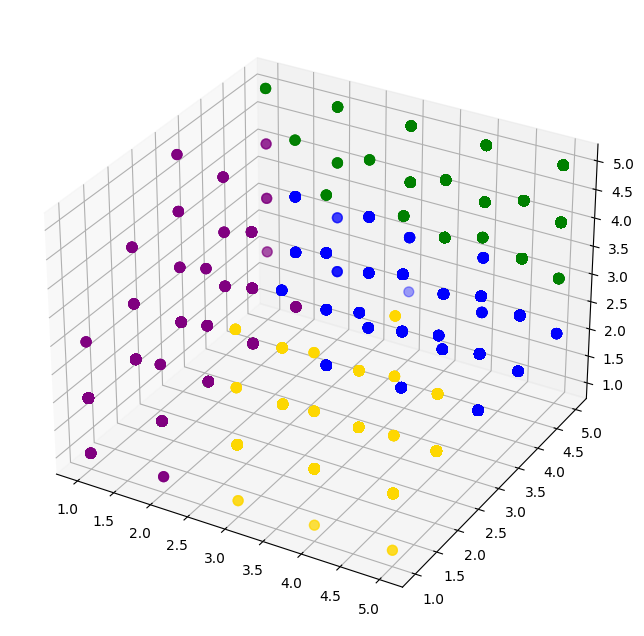

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
colors=['purple', 'blue', 'green', 'gold']
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111, projection='3d')
for i in range(kmeans.n_clusters):
    df_cluster=df2[df2['clusters']==i]
    ax.scatter(df_cluster['Recency_Flag'], df_cluster['Monetary_Flag'],df_cluster['Freq_Flag'],s=50,label='Cluster'+str(i+1), c=colors[i])
plt.legend()

ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2],s=200,marker='^', c='red', alpha=0.7, label='Centroids')

# 加強
實務上我們可以做得更精緻一點，例如：

可以分地區，每個地區個別作RFM，因為，各地區消費習慣可能不同，或者行銷活動的目標客群只鎖定某一區域。
篩選出來的客戶數，可經由K值控制，若篩選出來的客戶數太多，可以加大K值，或